# Load Environment

In [1]:
import time
import logging
from sys import stdout
from collections import deque

import cv2
import PIL
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from mlagents.envs.environment import UnityEnvironment

from agent import Agent

# set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

writer = SummaryWriter()

# env_name = 'sep_28'
env_name = 'oct_22'
path = "C:/data/ml-agents/scripts/envs/{}/UnitySDK.exe".format(env_name)
# env = UnityEnvironment(file_name="./envs/%s/%s.x86_64" % (env_name, env_name), worker_id=1, seed=1, no_graphics=False)
env = UnityEnvironment(file_name=path, worker_id=1, seed=1, no_graphics=False)


INFO:mlagents.envs:
'StationAcademy' started successfully!
Unity Academy name: StationAcademy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: DRLBrain
        Number of Visual Observations (per agent): 2
        Vector Observation space size (per agent): 3
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): [2, 2]
        Vector Action descriptions: , 


# Get environment info

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
brain_name, brain

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
logger.info('Number of actions: %s' % str(action_size))

# examine the vector space 
state = env_info.vector_observations[0]
logger.info('States look like: %s' % str(state))
state_size = len(state)
logger.info('States have length: %s' % str(state_size))

# examine the visual space
img = np.asarray(env_info.visual_observations)
# imgplt = plt.imshow(img[0][0])
height, width, channel = img[0][0].shape
logger.info('Shape of image: %s' % str(img[0][0].shape))

model_weight_name = 'checkpoint.pth'
agent = Agent(state_size=300, action_size=9, seed=0)

INFO:root:Number of actions: [2, 2]
INFO:root:States look like: [   0.            0.            0.            0.            0.
    0.         -659.69000244   -2.16580009  200.38999939]
INFO:root:States have length: 9
INFO:root:Shape of image: (300, 300, 3)


# A2C function

In [3]:
env_info = env.reset(train_mode=True)[brain_name]

In [4]:
%load_ext autoreload
%autoreload 2

def get_action(action):
    move_forward  = action // 3
    rotate = action % 3
    return [move_forward, rotate]

import copy
import glob
import os
import time
from collections import deque

# import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
# from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
# from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
# from evaluation import evaluate

observation_space = [3, 300, 300]
action_space = 9

# def a2c_ppo_acktr(env_info, al_type='a2c', gail=False, gail_experts_dir='./gail_experts', 
#                   gail_batch_size=128, gail_epoch=1e5, alpha=0.99, 
#                   gamma=0.99, use_gae=False, gae_lambda=0.95, 
#                   entropy_coef=0.01, value_loss_coef=0.5, max_grad_norm=0.5, 
#                   seed=False, num_processes=1, num_steps=5, ppo_epoch=4, num_mini_batch=32, 
#                   clip_param=0.2, log_interval=10, save_interval=100, eval_interval=None, 
#                   num_env_steps=10e6, env_name='PongNoFrameskip_v4', log_dir='/tmp/gym/', 
#                   save_dir='./trained_models/', no_cuda=False, use_proper_time_limits=False, 
#                   recurrent_policy=False, use_linear_lr_decay=False, cuda=True, cuda_deterministic=True, 
#                   eps=1e-5, lr=7e-4):

# ====== for testing
if True:
    
    al_type='a2c'
    gail=False
    gail_experts_dir='./gail_experts'
    gail_batch_size=128
    gail_epoch=1e5
    alpha=0.99
    gamma=0.99
    use_gae=False
    gae_lambda=0.95
    entropy_coef=0.01
    value_loss_coef=0.5
    max_grad_norm=0.5
    seed=False
    num_processes=1
    num_steps=1000
    ppo_epoch=4
    num_mini_batch=32
    clip_param=0.2
    log_interval=10
    save_interval=1000
    eval_interval=None
    num_env_steps=10e6
    env_name='PongNoFrameskip_v4'
    log_dir='/tmp/gym/'
    save_dir='./trained_models/'
    no_cuda=False
    use_proper_time_limits=False
    recurrent_policy=False
    use_linear_lr_decay=False
    cuda=True
    cuda_deterministic=True
    eps=1e-5
    lr=7e-4
    
# ====== for testing

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if cuda and torch.cuda.is_available() and cuda_deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    log_dir = os.path.expanduser(log_dir)
    eval_log_dir = log_dir + "_eval"
    utils.cleanup_log_dir(log_dir)
    utils.cleanup_log_dir(eval_log_dir)

    torch.set_num_threads(1)
    device = torch.device("cuda:0" if cuda else "cpu")
    
    # !!!!!! jtan
    # envs = make_vec_envs(env_name, seed, num_processes,
    #                      gamma, log_dir, device, False)
    
    # !!!!!! jtan
    # actor_critic = Policy(
    #     envs.observation_space.shape,
    #     envs.action_space,
    #     base_kwargs={'recurrent': recurrent_policy})
    actor_critic = Policy(
        observation_space,
        action_space,
        base_kwargs={'recurrent': recurrent_policy})
    
    actor_critic.to(device)

    if al_type == 'a2c':
        agent = algo.A2C_ACKTR(
            actor_critic,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            alpha=alpha,
            max_grad_norm=max_grad_norm)
    elif al_type == 'ppo':
        agent = algo.PPO(
            actor_critic,
            clip_param,
            ppo_epoch,
            num_mini_batch,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            max_grad_norm=max_grad_norm)
    elif al_type == 'acktr':
        agent = algo.A2C_ACKTR(
            actor_critic, value_loss_coef, entropy_coef, acktr=True)

    # if gail:
    #     assert len(envs.observation_space.shape) == 1
    #     discr = gail.Discriminator(
    #         envs.observation_space.shape[0] + envs.action_space.shape[0], 100,
    #         device)
    #     file_name = os.path.join(
    #         gail_experts_dir, "trajs_{}.pt".format(
    #             env_name.split('-')[0].lower()))

    #     gail_train_loader = torch.utils.data.DataLoader(
    #         gail.ExpertDataset(
    #             file_name, num_trajectories=4, subsample_frequency=20),
    #         batch_size=gail_batch_size,
    #         shuffle=True,
    #         drop_last=True)

    # rollouts = RolloutStorage(num_steps, num_processes,
    #                           envs.observation_space.shape, envs.action_space,
    #                           actor_critic.recurrent_hidden_state_size)
    
    rollouts = RolloutStorage(num_steps, num_processes,
                              observation_space, action_space,
                              actor_critic.recurrent_hidden_state_size)

    # !!!!!! jtan
    # obs = envs.reset()
    # obs = torch.from_numpy(np.transpose(np.asarray(env_info.visual_observations)[0][0], 
    #                       (2, 0, 1))) # get the next state
    obs = torch.from_numpy(np.transpose(np.asarray(env_info.visual_observations)[0], (0, 3, 1, 2)))
    reward = [env_info.rewards[0]]                   # get the reward
    done = [env_info.local_done[0]]                  # see if episode has finished
    
    # rollouts.obs[0].copy_(obs)
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)

    start = time.time()
    
    positions = []
    # !!!!!! jtan
    num_updates = int(
        num_env_steps) // num_steps // num_processes
    for j in range(num_updates):
        
        env_info = env.reset(train_mode=True)[brain_name]
        
        if use_linear_lr_decay:
            # decrease learning rate linearly
            utils.update_linear_schedule(
                agent.optimizer, j, num_updates,
                agent.optimizer.lr if algo == "acktr" else lr)
        
        score = 0
        position_epi = []
        
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            # !!!!!! jtan
            # obs, reward, done, infos = envs.step(action)
            
            # print('action', action)
            # print('action_log_prob', action_log_prob)
            
            action_transformed = get_action(action.cpu().numpy())
            
            # print('action_transformed', action_transformed)
            
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            obs = torch.from_numpy(np.transpose(np.asarray(env_info.visual_observations)[0], (0, 3, 1, 2))) # get the next state
            reward = torch.FloatTensor(env_info.rewards)        # get the reward
            done = torch.FloatTensor(env_info.local_done)       # see if episode has finished

            # for info in infos:
            #     if 'episode' in info.keys():
            #         episode_rewards.append(info['episode']['r'])

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            
            # zwang !!! don't know what it is doing, changing it to
            # bad_masks = torch.FloatTensor(
            #     [[0.0] if 'bad_transition' in info.keys() else [1.0]
            #      for info in infos])
            bad_masks = torch.FloatTensor([[1.0]])
                            
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)
            
            score += reward
            stdout.write('\r episode:{}, step: {}, position:({:.2f} {:.2f} {:.2f}), score:{}'.format(j, step,
                        env_info.vector_observations[0][-3:][0], env_info.vector_observations[0][-3:][1],
                        env_info.vector_observations[0][-3:][2], str(score)))
            stdout.flush()
            position_epi.append(env_info.vector_observations[0][-3:].tolist())

        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        if gail:
            if j >= 10:
                envs.venv.eval()

            gail_epoch = gail_epoch
            if j < 10:
                gail_epoch = 100  # Warm up
            for _ in range(gail_epoch):
                discr.update(gail_train_loader, rollouts,
                             utils.get_vec_normalize(envs)._obfilt)

            for step in range(num_steps):
                rollouts.rewards[step] = discr.predict_reward(
                    rollouts.obs[step], rollouts.actions[step], gamma,
                    rollouts.masks[step])

        rollouts.compute_returns(next_value, use_gae, gamma,
                                 gae_lambda, use_proper_time_limits)
        
        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()

        # save for every interval-th episode or for the last epoch
        if (j % save_interval == 0
                or j == num_updates - 1) and save_dir != "":
            save_path = os.path.join(save_dir, al_type)
            try:
                os.makedirs(save_path)
            except OSError:
                pass
            
            # !!!!!! jtan
            # torch.save([
            #     actor_critic,
            #     getattr(utils.get_vec_normalize(envs), 'ob_rms', None)
            # ], os.path.join(save_path, env_name + ".pt"))
            
            torch.save(
                actor_critic
            , os.path.join(save_path, env_name + ".pt"))
            
        # if j % log_interval == 0 and len(episode_rewards) > 1:
        #     total_num_steps = (j + 1) * num_processes * num_steps
        #     end = time.time()
        #     print(
        #         '''Updates {}, num timesteps {}, FPS {} \n Last {} training episodes
        #         : mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n'''
        #         .format(j, total_num_steps,
        #                 int(total_num_steps / (end - start)),
        #                 len(episode_rewards), np.mean(episode_rewards),
        #                 np.median(episode_rewards), np.min(episode_rewards),
        #                 np.max(episode_rewards), dist_entropy, value_loss,
        #                 action_loss))

        #if (eval_interval is not None and len(episode_rewards) > 1
        #        and j % eval_interval == 0):
        #    # !!!!!! jtan
        #    ob_rms = utils.get_vec_normalize(envs).ob_rms
        #    evaluate(actor_critic, ob_rms, env_name, seed,
        #             num_processes, eval_log_dir, device)
        
    positions.append(position_epi)

 episode:18, step: 131, position:(-514.25 -2.43 146.37), score:tensor([-1.3200]))

KeyboardInterrupt: 

# run a2c

In [ ]:
load_prev_model = 'model_latest'
# !!!!!! jtan
scores, positions = a2c_ppo_acktr(env_info)

# DQN function

In [ ]:

def dqn(env_info, n_episodes=1, max_t=2000, eps_start=1.0, eps_end=0.01, 
        eps_decay=0.995, target_scores=1.0, video_flag=True, load_prev_model=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        target_scores (float): average scores aming to achieve, the agent will stop training once 
                            it reaches this scores
        video_flag (boolean): a flag for whether to record video, if set to True, 
                            video would be recorded for every 20 episodes
    
    Returns
    ======
        scores in 2-d array
        positions in 2-d array
    
    """
    # load previous trained result
    if not load_prev_model == None:
        agent.qnetwork_local.load_state_dict(torch.load(load_prev_model))
    
    start = time.time()                       # Start time
    scores = []                               # list containing scores from each episode
    positions = []                            # position list
    scores_window = deque(maxlen=100)         # last 100 scores
    eps = eps_start                           # initialize epsilon
    
    
    width, height, channel = [300, 300, 3]
    
    for i_episode in range(1, n_episodes+1):
        
        video_flag = (i_episode % 20 == 0)
        
        # start video recording 
        if video_flag:
            fourcc = cv2.VideoWriter_fourcc('M','S','V','C') #Microspoft Video 1
            video  = cv2.VideoWriter('output_sep_18_%s.avi' % (str(i_episode)), fourcc, 30, (width, height))
            
        # Reset env and score at the beginning of episode
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment 
        
        # get the current visual state
        state = np.transpose(np.asarray(env_info.visual_observations)[0][0], (2, 0, 1)) 
        
        # initialize the score
        score = 0
        
        # storing temporary path for an episode
        position_epi = []
        
        for t in range(max_t):
            
            if video_flag:
                video.write(np.asarray(env_info.visual_observations)[0][0])
                
            action = agent.act(state, eps)
            
            # translate action variable into forward, rotate, and right
            action_transformed = get_action(action)
            env_info = env.step(action_transformed)[brain_name]        # send the action to the environment
            next_state = np.transpose(np.asarray(env_info.visual_observations)[0][0], 
                                      (2, 0, 1)) # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            
            score += reward
            
            position_epi.append(env_info.vector_observations[0][-3:].tolist())
            
            stdout.write('\r t:{}, position:{}, score:{:.3f}'.format(str(t), 
                                    str(env_info.vector_observations[0][-3:]), score))
            stdout.flush()
                                
        positions.append(position_epi)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\nEpisode {}\tAverage Score: {:.2f}\t Last Move {}\n'.format(i_episode, 
                                                        np.mean(scores_window), action_transformed), end="")
        if i_episode % 10 == 0:
            # torch.save(agent.qnetwork_local.state_dict(), 'model_%s' % str(i_episode))
            torch.save(agent.qnetwork_local.state_dict(), 'model_latest')
        
        # add rewards to writer
        writer.add_scalar('total_rewards', score, i_episode)
                
        # if np.mean(scores_window)>=target_scores:
        #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
        #                                                                      np.mean(scores_window)))
        #     torch.save(agent.qnetwork_local.state_dict(), model_weight_name)
        #     break
        
        if video_flag:
            cv2.destroyAllWindows()
            video.release()
    
    writer.close()

    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), model_weight_name)

    time_elapsed = time.time() - start
    print("Time Elapse: {:.2f}".format(time_elapsed))
    
    return scores, positions

# run DQN

In [4]:
load_prev_model = 'model_latest'
scores, positions = dqn(env_info, n_episodes=100, max_t=2000, eps_start=1.0, 
                        eps_end=0.01, eps_decay=0.995, target_scores=1.0,
                        video_flag=False, load_prev_model=load_prev_model)

FileNotFoundError: [Errno 2] No such file or directory: 'model_latest'

In [5]:
env_info = env.reset(train_mode=True)[brain_name]

In [6]:
goals = [[-252.8, -26.6, 118.7], [-184.0, -25.9, 89.9], 
         [-121.3, -19.5, 3.8], [-162.1, -27.1, 13.3], [-202.0, -27.3, 11.1],
        [40.9, -20.75, -30.8], [75.5, -28.1, -38.7]]
goals = [[i[0] - 388.5, i[1] + 24.4, i[2] + 80.5] for i in goals]
final_goal = [-342.9, 3.65, 48.0]

In [7]:
start = [positions[0][0][0], positions[0][0][1], positions[0][0][2]]

IndexError: list index out of range

In [8]:
pos = []
for i in range(len(positions)):
    # ignore the last item, as it might start from the origin
    a = [[a[0], a[1], a[2]] for a in positions[i]]
    pos.append(np.asarray(a[:-2]))

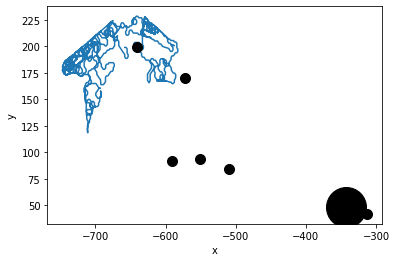

In [109]:
# final_goal = [-382.46, 54.69, 4]
for i in range(len(pos)):
    if i == 0:
        plt.plot(pos[i][:,0], pos[i][:,2])

for i in range(len(goals)):
    plt.plot(goals[i][0], goals[i][2], marker='o', markersize=10, color="black")

plt.plot([final_goal[0]], [final_goal[2]], marker='o', markersize=40, color="black")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [88]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# point_a = [[1093 - 888, 592 - 394], [1093 - 294, 592 - 92]]
point_a = [[205, 198], [799, 500]]
# point_b = [[-252.8 - 388.5, 118.7 + 80.5], [75.5 - 388.5, -38.7 + 80.5]]
point_b = [[-641.3, -199.2], [-313.0, -41.8]]

a = math.sqrt((point_a[0][0] - point_a[1][0])**2 + (point_a[0][1] - point_a[1][1])**2)
b = math.sqrt((point_b[0][0] - point_b[1][0])**2 + (point_b[0][1] - point_b[1][1])**2)
ratio = a / b
plus = [point_a[0][0] - point_b[0][0] * ratio, point_a[0][1] - point_b[0][1] * ratio]
print(point_b[0][0] * ratio + plus[0], point_b[0][1] * ratio + plus[1])
print(point_b[1][0] * ratio + plus[0], point_b[1][1] * ratio + plus[1])
# print([[i[0] * ratio + , i[i] * ratio + ] for ])

205.0 197.99999999999994
805.8731636688163 486.0823513904103


In [89]:
ratio

1.8302563620737633

In [96]:
trans_pos = [np.array([[j[0] * ratio + plus[0], j[1], j[2] * ratio + plus[1]] for j in i]) for i in pos]

In [97]:
# trans_pos

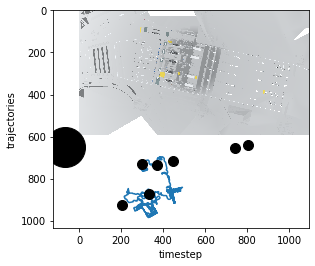

In [98]:
img = mpimg.imread('./plan.png')
plt.imshow(img)

for i in range(len(trans_pos)):
    if i == 11:
        plt.plot(trans_pos[i][:,0], trans_pos[i][:,2])

for i in range(len(goals)):
    plt.plot(goals[i][0]  * ratio + plus[0], goals[i][2]  * ratio + plus[1], marker='o', markersize=10, color="black")

plt.plot([final_goal[0] * ratio + plus[1]], [final_goal[2] * ratio + plus[1]], marker='o', markersize=40, color="black")
plt.xlabel('timestep')
plt.ylabel('trajectories')
plt.show()

In [99]:
imgs = np.expand_dims(np.asarray(env_info.visual_observations)[0][0], axis=0)
input = np.transpose(imgs, (0, 3, 1, 2))
input = np.concatenate([input, input, input, input], 0)
print(input.shape)

m1  = torch.nn.Conv2d(3, 32, kernel_size=8, stride=4)
m2  = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
m3  = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
fc4 = torch.nn.Linear(34 * 34 * 64, 512)
fc5 = torch.nn.Linear(512, 9)

input = torch.randn(1, 3, 300, 300)
output1 = m1(input)
print(output1.shape)
output2 = m2(output1)
print(output2.shape)
output3 = torch.flatten(m3(output2))
print(output3.shape)
output4 = fc4(output3)
print(output4.shape)
output5 = fc5(output4)

# fc5(fc4(m3(m2(m1(input)))))


(4, 3, 300, 300)
torch.Size([1, 32, 74, 74])
torch.Size([1, 64, 36, 36])
torch.Size([73984])
torch.Size([512])


In [ ]:
input = torch.randn(3, 300, 300)
input = input.unsqueeze(0)

In [ ]:
input.shape

In [ ]:
output5

In [ ]:
plt.imshow(np.asarray(env_info.visual_observations)[0][0])

In [ ]:

# plot the scores
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(len(scores)), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [ ]:
print(agent.chck[1])

In [ ]:
agent.qnetwork_local(agent.chck[0].unsqueeze(0))

### Watch the agent running ( Using saved weights)

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load(model_weight_name))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

### Close Unity ML Environment

In [ ]:
env.close()